<a href="https://colab.research.google.com/github/isteiner93/home_assignment/blob/main/sentinel_logs_analysis_final_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install_logs dataset analysis

## Libraries

In [3]:
!pip install awswrangler pandas altair

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.0/379.0 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 10.2 MB/s eta 0:00:00


In [1]:
!pip install -q vl-convert-python altair_saver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 844.5/844.5 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 25.8 MB/s eta 0:00:00




---



## Athena Connection


In [4]:
import os
import getpass

# Prompt for AWS credentials securely (no visible output)
os.environ["AWS_ACCESS_KEY_ID"] = getpass.getpass("Enter your AWS_ACCESS_KEY_ID: ")
os.environ["AWS_SECRET_ACCESS_KEY"] = getpass.getpass("Enter your AWS_SECRET_ACCESS_KEY: ")
os.environ["AWS_DEFAULT_REGION"] = "eu-north-1"


Enter your AWS_ACCESS_KEY_ID: ··········
Enter your AWS_SECRET_ACCESS_KEY: ··········




---



## Load table (dataset)


**I am already loading Athena cleaned & parsed data. So partial data validation has been done already in Glue Job**

Compared to the original .csv, data in Athena has gone through the following cleaning:

1.   Tries reading CSV using default comma , delimiter
2.   Checks for the presence of all required columns
3.   Cast `time` to timestamp.
4.   Cast `installation_succeed` to boolean.
5.   Cast `installation_duration_milliseconds` to bigint.
5.   DROP nulls `df.dropna(subset=["time", "id"])` --> only for critical fields (not all columns with NULLs)


In [5]:
import awswrangler as wr
import pandas as pd

# Configuration - loading table
ATHENA_DATABASE = "s1_logs_db"
SQL_QUERY = """
SELECT *
FROM s1_logs_db.install_logs
"""

# Run Athena query
df = wr.athena.read_sql_query(
    sql=SQL_QUERY,
    database=ATHENA_DATABASE
)

# Preview the result
df.head(10)


,time,id,os,device,version,error_code,installation_duration_milliseconds,installation_succeed,partition_0,partition_1
0,2023-05-14 15:29:01.357,6f2cbe50-339e-49b2-967d-d8edfc26d1ae,Windows,Desktop,1.0.1,00,314863,True,glue_job,installations.parquet
1,2023-05-14 15:29:01.357,0d72e214-a8b0-4070-ae91-69243bdf2d0e,Mac OS,Laptop,2.0.3,00,167584,True,glue_job,installations.parquet
2,2023-05-14 15:29:01.357,6906889f-db03-4f7b-9e3c-fbe542598930,Linux,Desktop,1.0.2,00,785258,True,glue_job,installations.parquet
3,2023-05-14 15:29:01.357,679d112c-6b79-4443-be58-89942645c4c9,Linux,Server,1.0.2,00,866948,True,glue_job,installations.parquet
4,2023-05-14 15:29:01.357,9eb58561-1495-43e1-8eed-520e1c8e6714,Linux,Laptop,1.0.2,00,719791,True,glue_job,installations.parquet
5,2023-05-14 15:29:01.357,4c24eaaa-e986-4677-a9f1-bbfbbc5b7c23,Mac OS,Desktop,2.0.4,22,227370,False,glue_job,installations.parquet
6,2023-05-14 15:29:01.357,ac36ea9c-b819-40e1-8f29-63748e1d5e3f,Mac OS,Desktop,2.0.3,00,708917,True,glue_job,installations.parquet
7,2023-05-14 15:29:01.357,fecf2375-43da-427e-b39d-315599698c74,Linux,Desktop,1.0.2,00,161942,True,glue_job,installations.parquet
8,2023-05-14 15:29:01.357,0d72e214-a8b0-4070-ae91-69243bdf2d0e,Mac OS,Laptop,2.0.3,00,167584,True,glue_job,installations.parquet
9,2023-05-14 15:29:01.357,843ae8c1-a240-4d95-81da-e7d918160d12,Mac OS,Desktop,2.0.3,00,829500,True,glue_job,installations.parquet




---



## Data validation

### Data Profiling



Here are some basic findings:
1. `error_code` has 17 missing values - this is intended, but important to note.

2.  There are some ID duplicates (`985 unique IDs out of 994 rows`). Important to know the dataset is not unique on ID level & when transforming data further (e.g. in dbt) we should consider this & write proper validation tests for new models.

3. We can see negative time values for `installation_duration_milliseconds` (logically problematic). We should again consider this when writing further transformation during aggregating. We can also possibly drop these rows.

In [6]:
# 1. Data Profiling and Summary
print("=== Data Profiling Summary ===")
print("\n--- Column Data Types ---")
print(df.dtypes)

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Unique Values ---")
print(df.nunique())

print("\n--- Basic Statistical Summary ---")
print(df.describe(include='all'))


=== Data Profiling Summary ===

--- Column Data Types ---
time                                  datetime64[ns]
id                                    string[python]
os                                    string[python]
device                                string[python]
version                               string[python]
error_code                            string[python]
installation_duration_milliseconds             Int64
installation_succeed                         boolean
partition_0                           string[python]
partition_1                           string[python]
dtype: object

--- Missing Values ---
time                                   0
id                                     0
os                                     0
device                                 0
version                                0
error_code                            17
installation_duration_milliseconds     0
installation_succeed                   0
partition_0                            0
parti



---



### Schema Validation

In the next step we can again **check if the data types of the table** (file) is as expected. We have done this already in the Glue Spark Job, but lets check again.

As seen below all the columns match expected schema columns ✅

In [7]:
# 2. Schema Validation
print("\n=== Schema Validation ===")

# Defined schema as expected
expected_schema = {
    'time': 'datetime64[ns]',
    'id': 'string',
    'os': 'string',
    'device': 'string',
    'version': 'string',
    'error_code': 'string',
    'installation_duration_milliseconds': 'Int64',
    'installation_succeed': 'boolean'
}

# Schema validation
print("\n--- Schema Mismatches ---")
for col, expected_type in expected_schema.items():
    if col in df.columns:
        actual_type = str(df[col].dtype)
        if actual_type == expected_type:
            print(f"[Match] Column '{col}': Expected {expected_type}, Found {actual_type}")
        if actual_type != expected_type:
            print(f"[Mismatch] Column '{col}': Expected {expected_type}, Found {actual_type}")
    else:
        print(f"[Missing] Column '{col}' is not in the DataFrame")



=== Schema Validation ===

--- Schema Mismatches ---
[Match] Column 'time': Expected datetime64[ns], Found datetime64[ns]
[Match] Column 'id': Expected string, Found string
[Match] Column 'os': Expected string, Found string
[Match] Column 'device': Expected string, Found string
[Match] Column 'version': Expected string, Found string
[Match] Column 'error_code': Expected string, Found string
[Match] Column 'installation_duration_milliseconds': Expected Int64, Found Int64
[Match] Column 'installation_succeed': Expected boolean, Found boolean




---



### Data quality


Here we can confirm:
1. Again **17** empty `error_code` values
2. Again we see **6** records with `installation_duration_milliseconds < 0`.
3. No invalid booleans ✅

In [8]:
# 3. Data Quality Checks
print("\n=== Data Quality Checks ===")

# Check 1: Null values in required fields
required_fields = list(expected_schema.keys())
null_issues = df[required_fields].isnull().sum()
print("\n--- Null Values in Required Fields ---")
print(null_issues[null_issues > 0])

# Check 2: Negative installation durations (invalid)
negative_durations = df[df['installation_duration_milliseconds'] < 0]
print("\n--- Negative Installation Durations ---")
print(negative_durations)

# Check 3: Non-boolean values in installation_succeed
invalid_bool = df[~df['installation_succeed'].isin([True, False, pd.NA])]
print("\n--- Invalid Boolean Entries in 'installation_succeed' ---")
print(invalid_bool)


=== Data Quality Checks ===

--- Null Values in Required Fields ---
error_code    17
dtype: int64

--- Negative Installation Durations ---
                       time                                    id      os  \
232 2023-05-14 15:29:01.361  759377ae-eeb4-4e86-9169-f89be04aac27   Linux   
262 2023-05-14 15:29:01.362  e98807b8-c444-4c6f-8037-fe212d5b1d54   Linux   
320 2023-05-14 15:29:01.363  ec91e6b1-2783-44ad-a009-aa624a461e06  Mac OS   
359 2023-05-14 15:29:01.364  1949aadb-9d73-4cf1-9c44-ab503da82f71  Mac OS   
570 2023-05-14 15:29:01.368  584ecc95-e633-41ac-a999-36b0de454b6f   Linux   
674 2023-05-14 15:29:01.370  3adbbc6e-5ad9-4059-a0e8-5dec764b108c  Mac OS   

      device version error_code  installation_duration_milliseconds  \
232  Desktop   1.0.2         00                                 -13   
262  Desktop   1.0.2         00                                 -13   
320  Desktop   2.0.3         00                                 -13   
359  Desktop   2.0.3         00     



---



## Saves as .parquet

In [ ]:
# Save as Parquet locally
df.to_parquet("install_logs.parquet", index=False)
print("File saved")

File saved


## Data Analysis

Lets start by `df.describe` the dataset.
This shows again few interesting facts about the dataset:
1. `time` spread is very small (few miliseconds)
2. negative values for `installation_duration_milliseconds` (-13)

In [9]:
df.describe()

,time,installation_duration_milliseconds
count,994,994.0
mean,2023-05-14 15:29:01.366558464,531515.720322
min,2023-05-14 15:29:01.357000,-13.0
25%,2023-05-14 15:29:01.360999936,295171.0
50%,2023-05-14 15:29:01.366000128,524194.0
75%,2023-05-14 15:29:01.372000,762584.75
max,2023-05-14 15:29:01.376000,999774.0
std,NaN,266314.701661




---



### Logs Count Distribution
Below a **size distribution** of values across 3 dimentions (version, os, device).

As we can see version 2.0.3, macOS and Desktop being the biggest contributors to the dataset (largest count of logs)

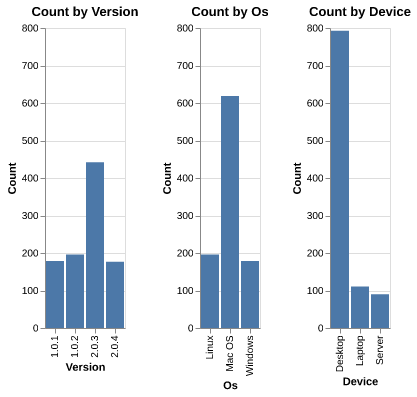

In [27]:
import pandas as pd
import altair as alt
from IPython.display import Image

def plot_installation_count_chart(df, category_column):
    if category_column not in df.columns:
        print(f"Error: Column '{category_column}' not found in the DataFrame.")
        return

    # Prepare count data
    count_df = df[category_column].value_counts().reset_index()
    count_df.columns = [category_column, 'count']

    # Create bar chart
    chart = alt.Chart(count_df).mark_bar().encode(
        x=alt.X(f'{category_column}:N', title=category_column.capitalize()),
        y=alt.Y('count:Q', title='Count'),
        tooltip=[category_column, 'count']
    ).properties(
        title=f'Count by {category_column.capitalize()}'
    )

    return chart

# Create individual charts
chart_version = plot_installation_count_chart(df, 'version')
chart_os = plot_installation_count_chart(df, 'os')
chart_device = plot_installation_count_chart(df, 'device')

# Combine charts horizontally
combined_chart = (chart_version | chart_os | chart_device).resolve_axis(
    x='independent'
).resolve_scale(
    y='shared'
)

# Save chart to PNG
combined_chart.save('installation_counts.png')

# Display in notebook
Image('installation_counts.png')



---



### Installation success rate
Below of **installation sucess rate per os, per device**
Couple of findings:
1. version `2.0.4` has a significantly lower installation success rate
2. similarly macOS is the only os with error rate, but it also is the most common os

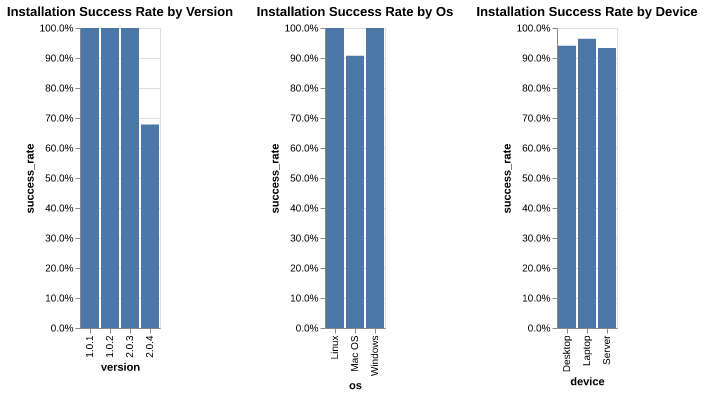

In [28]:
import pandas as pd
import altair as alt
from IPython.display import Image

def plot_installation_success_rate(df, category_column):
    if category_column not in df.columns:
        print(f"Error: Column '{category_column}' not found in the DataFrame.")
        return

    # Group by the category and calculate the success rate
    summary_df = df.groupby(category_column)['installation_succeed'].agg(['sum', 'count']).reset_index()
    summary_df['success_rate'] = summary_df['sum'] / summary_df['count']

    # Create the bar chart
    chart = alt.Chart(summary_df).mark_bar().encode(
        x=alt.X(category_column),
        y=alt.Y('success_rate', axis=alt.Axis(format='.1%')),
        tooltip=[category_column, 'success_rate', 'sum', 'count']
    ).properties(
        title=f'Installation Success Rate by {category_column.capitalize()}'
    )

    return chart

# Example usage:
chart_os = plot_installation_success_rate(df, 'os')
chart_device = plot_installation_success_rate(df, 'device')
chart_version = plot_installation_success_rate(df, 'version')


# Combine the charts horizontally
combined_chart = (chart_version | chart_os | chart_device).resolve_axis(
    x='independent'
).resolve_scale(
    y='shared'
)

# Save chart to PNG (requires vl-convert-python + altair_saver)
combined_chart.save('mean_duration_chart.png')

# Display in notebook
Image('mean_duration_chart.png')



---



### Mean installation duration per categories
In this section, I am exploring the average time it takes to install the system per different categories.

As seen in the graphs, the longest on average it takes on Windows, Deskptop and for version 1.0.1

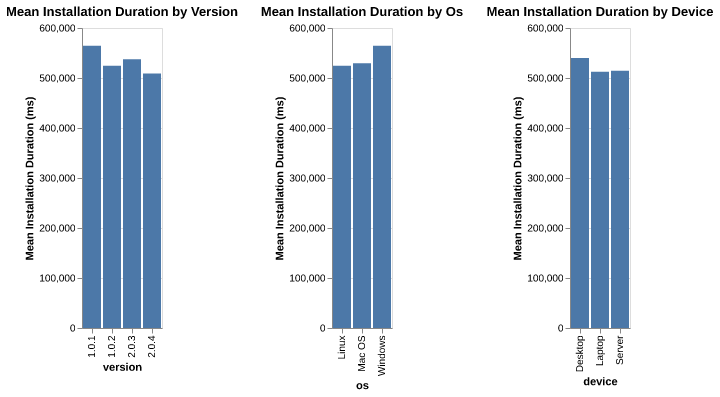

In [29]:
import pandas as pd
import altair as alt
from IPython.display import Image

def plot_mean_installation_duration(df, category_column):
    if category_column not in df.columns:
        print(f"Error: Column '{category_column}' not found in the DataFrame.")
        return None

    # Filter positive durations
    df_positive = df[df['installation_duration_milliseconds'] >= 0].copy()

    # Group and calculate mean duration
    summary_df = df_positive.groupby(category_column)['installation_duration_milliseconds'].mean().reset_index()
    summary_df.columns = [category_column, 'mean_duration']

    # Create bar chart
    chart = alt.Chart(summary_df).mark_bar().encode(
        x=alt.X(category_column),
        y=alt.Y('mean_duration', title='Mean Installation Duration (ms)'),
        tooltip=[category_column, 'mean_duration']
    ).properties(
        title=f'Mean Installation Duration by {category_column.replace("_", " ").title()}'
    )

    return chart

# Generate charts
chart_os = plot_mean_installation_duration(df, 'os')
chart_device = plot_mean_installation_duration(df, 'device')
chart_version = plot_mean_installation_duration(df, 'version')

# Combine horizontally
combined_chart = (chart_version | chart_os | chart_device).resolve_axis(
    x='independent'
).resolve_scale(
    y='shared'
)

# Save chart to PNG (requires vl-convert-python + altair_saver)
combined_chart.save('mean_duration_chart.png')

# Display in notebook
Image('mean_duration_chart.png')



---



### Box Plot Installation Duration - check
To make sure we don't count in some large outliers when checking the mean average duration times, we can visualize it with **boxplot** per all categories.

As we can see, there aren't any significat outliers that would siginificantly impact the data analysis. The distribution is similar for all caregories.

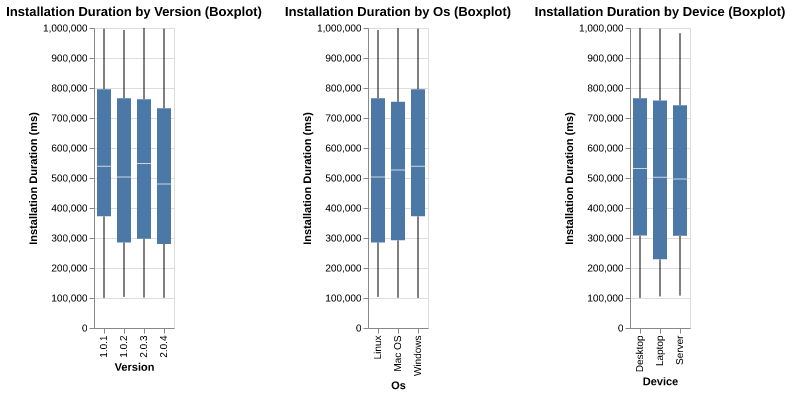

In [30]:
import pandas as pd
import altair as alt
from IPython.display import Image

def plot_duration_boxplot(df, category_column):
    if category_column not in df.columns:
        print(f"Error: Column '{category_column}' not found in the DataFrame.")
        return None

    # Filter out negative durations
    df_filtered = df[df['installation_duration_milliseconds'] >= 0].copy()

    # Create boxplot
    chart = alt.Chart(df_filtered).mark_boxplot().encode(
        x=alt.X(category_column, title=category_column.replace('_', ' ').title()),
        y=alt.Y('installation_duration_milliseconds', title='Installation Duration (ms)'),
        tooltip=[category_column, 'installation_duration_milliseconds']
    ).properties(
        title=f'Installation Duration by {category_column.replace("_", " ").title()} (Boxplot)'
    )

    return chart

# Generate individual boxplots
chart_os = plot_duration_boxplot(df, 'os')
chart_device = plot_duration_boxplot(df, 'device')
chart_version = plot_duration_boxplot(df, 'version')

# Combine charts horizontally
combined_chart = (chart_version | chart_os | chart_device).resolve_axis(
    x='independent'
).resolve_scale(
    y='shared'
)

# Save to PNG
combined_chart.save('boxplot_duration_chart.png')

# Display in Colab
Image('boxplot_duration_chart.png')

### Distribution of installation duration
In this section we looked at the distribution of `installation_duration_milliseconds` across all categorical dimensions.

What is interesting to see here is that there is NOT a normal distribution (gausian distribution) and we see the times (frequency) being split similarly across all time blocks.

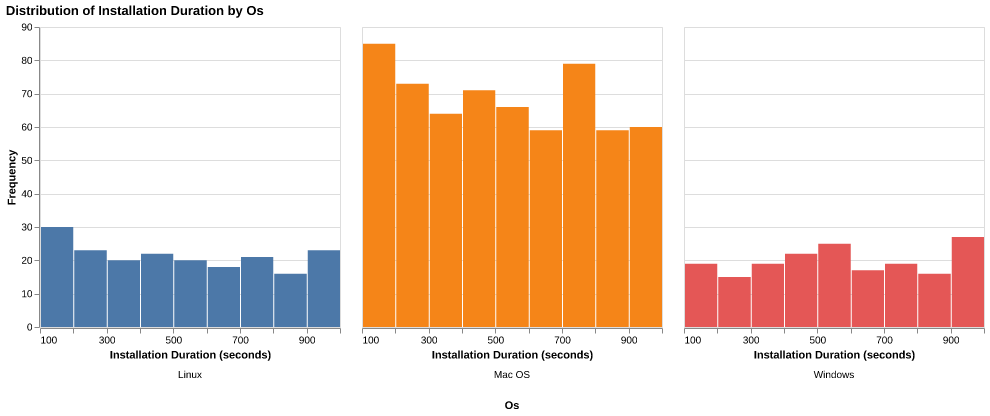

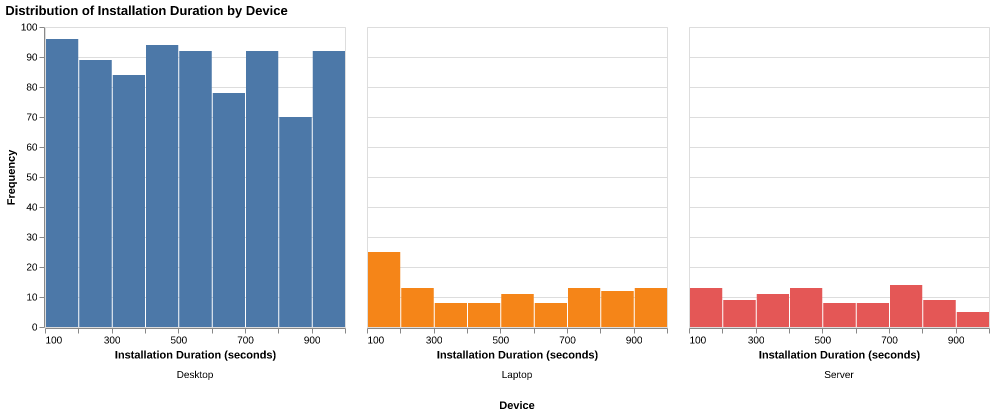

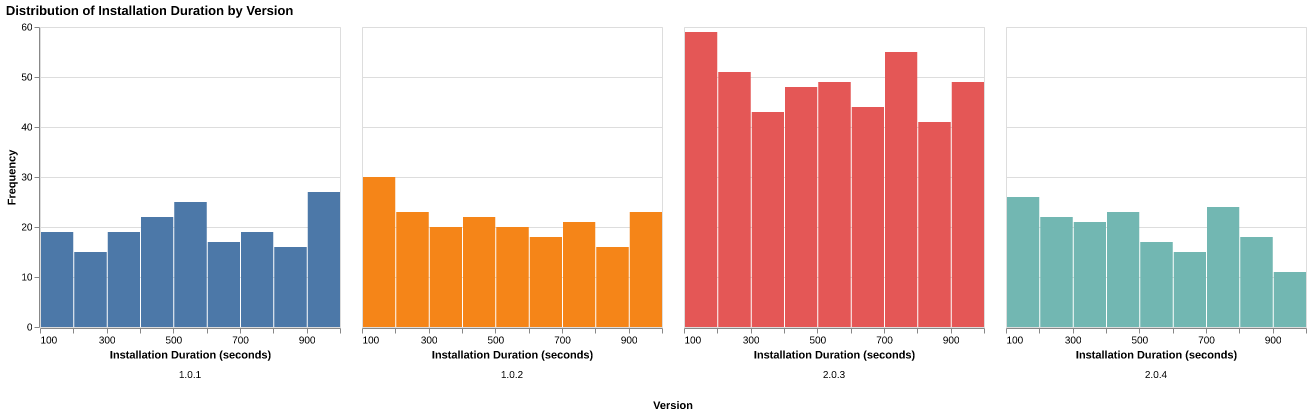

In [31]:
import pandas as pd
import altair as alt
from IPython.display import Image

def plot_duration_histogram(df, category_column):
    if category_column not in df.columns:
        print(f"Error: Column '{category_column}' not found in DataFrame.")
        return None

    # Filter negative durations and convert to seconds
    df_filtered = df[df['installation_duration_milliseconds'] >= 0].copy()
    df_filtered['installation_duration_seconds'] = df_filtered['installation_duration_milliseconds'] / 1000

    # Create faceted histogram chart
    chart = alt.Chart(df_filtered).mark_bar().encode(
        x=alt.X('installation_duration_seconds:Q', bin=True, title='Installation Duration (seconds)'),
        y=alt.Y('count()', title='Frequency'),
        color=alt.Color(f'{category_column}:N', legend=None),
        column=alt.Column(f'{category_column}:N',
                          header=alt.Header(title=category_column.replace("_", " ").title(),
                                            titleOrient="bottom", labelOrient="bottom"))
    ).properties(
        title=f'Distribution of Installation Duration by {category_column.replace("_", " ").title()}'
    )

    return chart

# Generate individual histograms
chart_os = plot_duration_histogram(df, 'os')
chart_device = plot_duration_histogram(df, 'device')
chart_version = plot_duration_histogram(df, 'version')

# Display or export charts
chart_os.save('duration_histogram_os.png')
chart_device.save('duration_histogram_device.png')
chart_version.save('duration_histogram_version.png')

# Display in notebook (Colab)
display(Image('duration_histogram_os.png'))
display(Image('duration_histogram_device.png'))
display(Image('duration_histogram_version.png'))